Graphs from `ui` package
=====================
Demonstrations of re-usable functions to make "standard" graphs.

In [1]:
# automatically reload changes we make to schools.py and ui.py
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

# graphs and viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import networkx as nx

import math

from IPython.display import Markdown as md
from nycschools import schools, ui, exams, nysed


env_dir:  /home/mxc/Documents/nycschools/school-data
setting data dir to env:  /home/mxc/Documents/nycschools/school-data


In [25]:
# load the demographic data and merge it with the ELA data
df = schools.load_school_demographics()

# load the data from the csv file
ela = exams.load_ela()
#drop the rows with NaN (where the pop is too small to report)
ela = ela[ela["mean_scale_score"].notnull()]
ela = df.merge(ela, how="inner", on=["dbn", "ay"])
ela = ela.query("ay == 2018 and category == 'All Students'")


Grouped Bar Chart
---------------------------
`ui.plot_group_bars`

Here we're going to plot the demographic data for Stuvesant, Bronx Science, and Brooklyn Tech
high schools. These three schools' admissions are set by NYS law to be based on scores on the SHSAT
exam. Other schools also use this exam for admissions, but NYC DOE can change the criteria for the
other "specialized" schools without seeking permission from NYS.

In [38]:
df = schools.load_school_demographics()

dbn =["02M475", "13K430", "10X445"]
special = df[df["dbn"].isin(dbn)]
special = special[special["year"] == special.year.max()]

cols = ['dbn','school_name', 'total_enrollment', 'asian_pct', 'black_pct', 'hispanic_pct','white_pct', 'poverty_pct']
special = special[cols]
pretty_cols = ['id', 'school', 'total students', '% asian', '% black', '% hispanic', '% white', '% poverty']

# spec = pd.melt(totals, id_vars=id_cols, value_vars=cats, var_name="enroll_cat", value_name="enrollment")
# data = pd.melt(special, id_vars=cols[:3], value_vars=cols[3:], var_name="pct_cat", value_name="pct")

data = special.copy()
for col in cols[3:]:
    data[col] = data[col].apply(lambda x: x * 100)

data

,dbn,school_name,total_enrollment,asian_pct,black_pct,hispanic_pct,white_pct,poverty_pct
656,02M475,Stuyvesant High School,3342,71.4,1.4,3.8,17.6,45.4
2955,10X445,The Bronx High School of Science,2936,64.4,3.2,7.8,20.9,47.2
3723,13K430,Brooklyn Technical High School,5921,59.9,5.6,6.6,23.7,59.0


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (10001,).

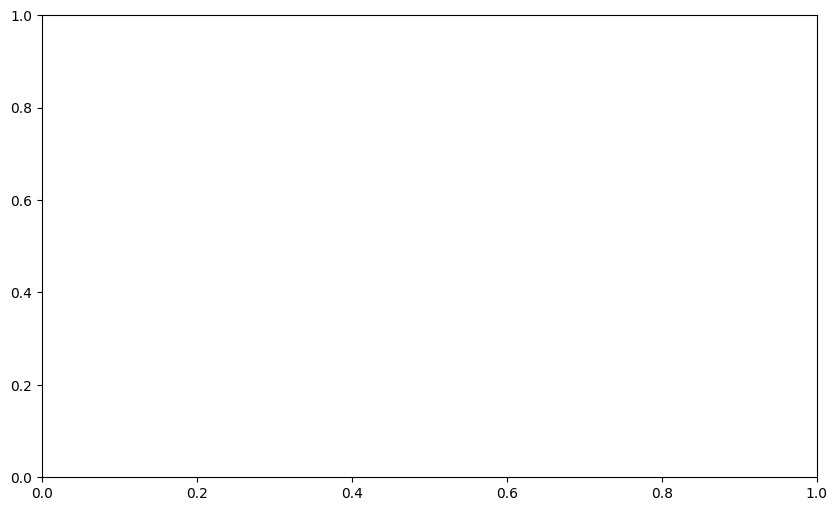

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
labels = data["school_name"]
index = df.index
width = 0.25
opacity = 1
x = np.arange(len(labels))
asian = ax.bar(x-width/2, df["asian_pct"], width, label="Asian")
black = ax.bar(x-width/2, df["black_pct"], width, label="Black")
ax.set_ylabel('Percent')
ax.set_title("School Demographics")
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(asian, padding=3)
ax.bar_label(black, padding=3)

fig.tight_layout()
fig.show()


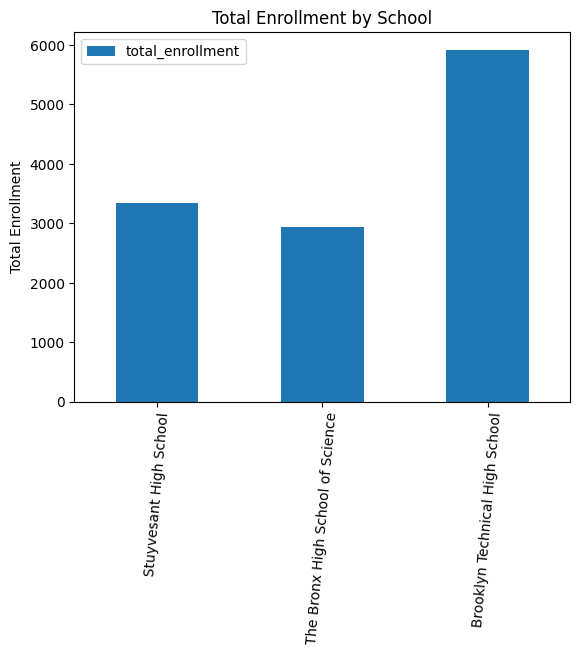

In [32]:
ax = special.plot.bar(x="school_name", y="total_enrollment", rot=85, title="Total Enrollment by School", xlabel="", ylabel="Total Enrollment")


TypeError: Axes.bar() missing 1 required positional argument: 'height'

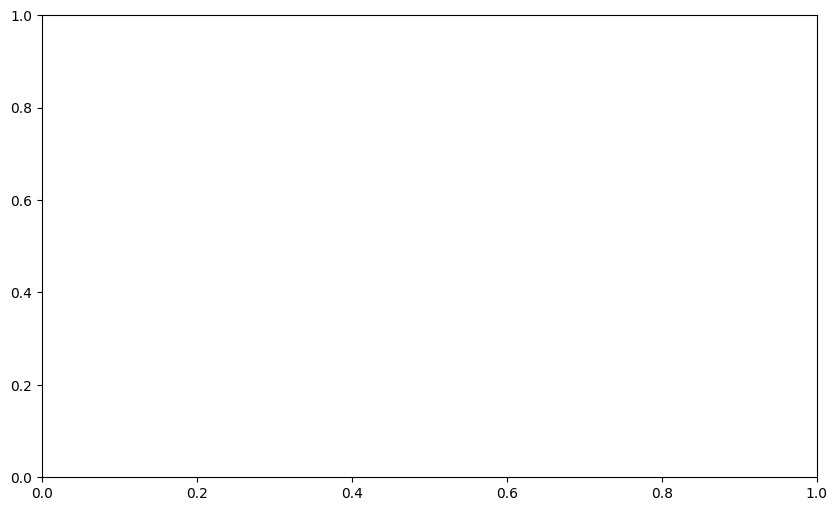

In [31]:
def plot_grouped_bar_chart(df, x_col, group_cols, labels,y_label="", x_label=None, title=""):
    fig, ax = plt.subplots(figsize=(10, 6))
    index = df.index
    bar_width = 0.25
    opacity = 1
    x = np.arrange(len(df))

    for i in range(len(group_cols)):
        rect = ax.bar(df[group_cols[i]], width=bar_width, label=labels[i])

    # for i, bar in enumerate(bar_cols, 1):
    #     ax.bar(i*w, data[bar], width=w, label=ui.nice_name(bar))

    if x_label == None:
        x_label = x_col
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(index + (len(group_cols) - 1) * bar_width / 2)
    ax.set_xticklabels(df[x_col], rotation=85)
    ax.legend()

    y_min, y_max = min(df[group_cols].min()), max(df[group_cols].max())
    ax.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

plot_grouped_bar_chart(data, "school_name", cols[3:], pretty_cols[3:],y_label="Percent", x_label="", title="Demographics by School")


In [10]:

special["school_name"] = special.apply(lambda row: f"{row.school_name} (n={row.total_enrollment})", axis = 1)
special = special[["school_name", "pct_cat", "pct"]].groupby(["school_name", "pct_cat"]).agg(max)

special = special.reset_index("school_name")
special

KeyError: "['pct_cat', 'pct'] not in index"

In [ ]:
def config_plot(title="", y_label="", size=(12, 9),):
    fig, ax = plt.subplots(figsize=size)

    sns.set_context('talk')

    # Set the y-axis label
    ax.set_ylabel(y_label, labelpad=15)

    # Axis styling.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#efefef')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#efefef')
    ax.xaxis.grid(False)

    ax.legend()
    fig.tight_layout()
    ax.set_title(title, pad=40)
    return fig, ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:title={'center':'Specialized High School Demographics'}>

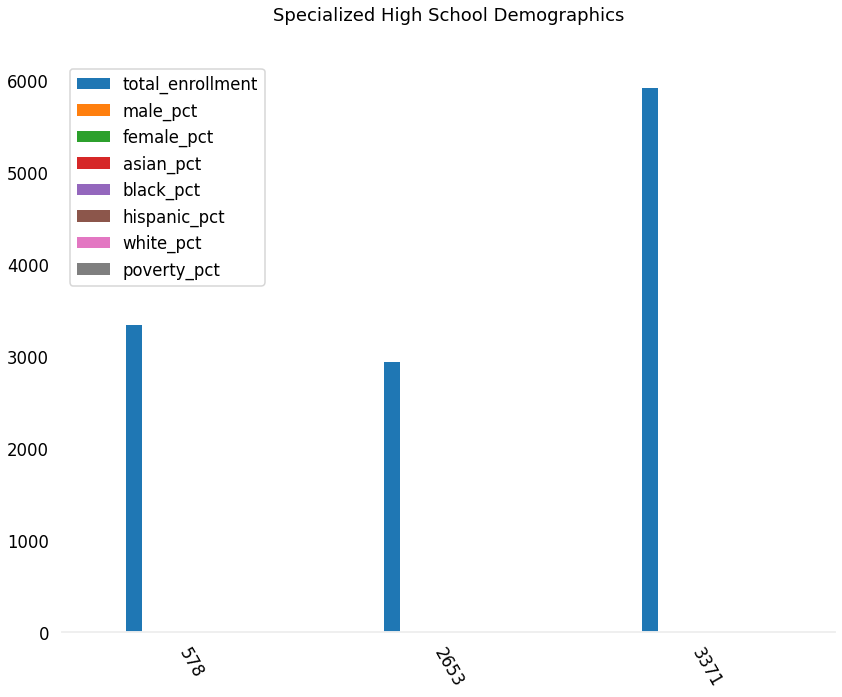

In [140]:

# special = special.drop("dbn", axis=1)
special.groupby("school_name").agg(max)
fig, ax = config_plot(title="Specialized High School Demographics")
special.plot.bar(ax=ax, rot=-60)


In [114]:
dbn =["02M475", "13K430", "10X445"]
special = df[df["dbn"].isin(dbn)]
special = special[special["year"] == special.year.max()]


special[schools.demo.core_cols].columns
cols = ['dbn','school_name', 'total_enrollment', 'male_pct', 'female_pct',
       'asian_pct', 'black_pct', 'hispanic_pct','white_pct', 'poverty_pct']
special = special[cols]

labels = special.school_name.unique()
labels = ["asian", "black"]
bars = [
    special.asian_pct.mean(),
    special.black_pct.mean()
]
speed = [0.1, 17.5, 40, 48, 52, 69, 88]

lifespan = [2, 8, 70, 1.5, 25, 12, 28]

index = ['snail', 'pig', 'elephant',

         'rabbit', 'giraffe', 'coyote', 'horse']



foo = pd.DataFrame({'speed': speed, 'lifespan': lifespan}, index=index)

display(special)
data = special.copy()
data.set_index
ax = data.plot.bar(rot=-60)

# for label, bar in bars:
#     r = ax.bar()
# width = .25
# x = np.arange(len(bars))
# fig, ax = config_plot(title="Specialized High School Demographics")


# add the bars
# for i, bar in enumerate(bar_cols, 1):
#     ax.bar(i*w, data[bar], width=w, label=ui.nice_name(bar))

# set the x-ticks to the middle of the bar groups and add labels
#     ax.set_xticks(x + (w * len(bar_cols)) / 2)
# ax.set_xticklabels(data[x_cols])

# add the bars
# for i, bar in enumerate(bar_cols, 1):
#     ax.bar(i*w, data[bar], width=w, label=ui.nice_name(bar))

# set the x-ticks to the middle of the bar groups and add labels
#     ax.set_xticks(x + (w * len(bar_cols)) / 2)
# ax.set_xticklabels(data[x_cols])



SyntaxError: invalid syntax (1785676820.py, line 31)

/tmp/ipykernel_6085/1098052182.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data[x_cols])


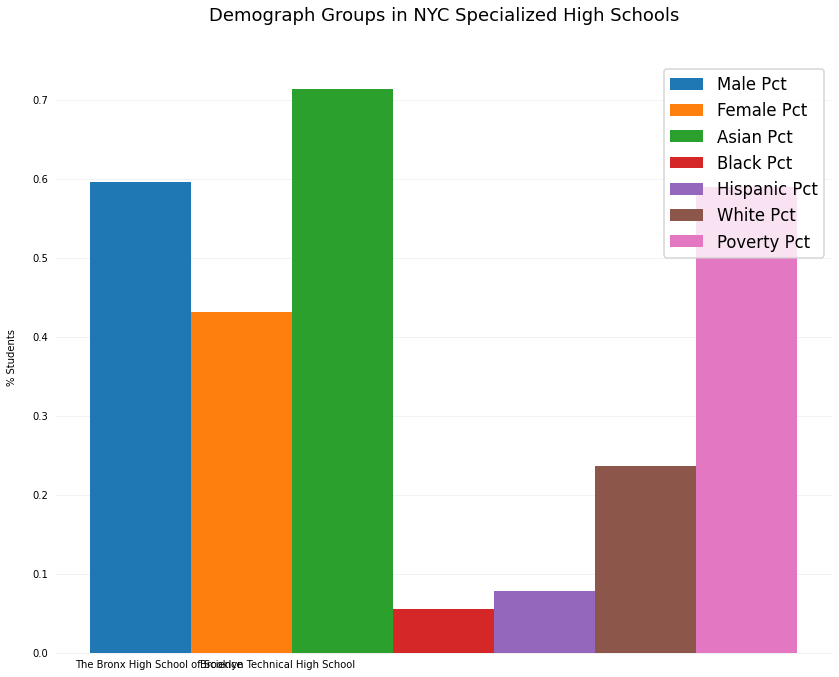

In [65]:
bar_cols = cols[3:]
data = special.copy()
x_label = "school_name"

def plot_group_bars(data, bar_cols, x_cols, y_label, title=""):
    # get the tick marks for the x access
    x = np.arange(len(bar_cols))

    # instead of plotting the dataframe, get the figure and axis components from the plot
    fig, ax = plt.subplots(figsize=(12, 9))

    # the bar width in inches
    w = .17
    
    # add the bars
    for i, bar in enumerate(bar_cols, 1):
#         print(x*i*w)
        ax.bar(i*w, data[bar], width=w, label=ui.nice_name(bar))

    # set the x-ticks to the middle of the bar groups and add labels
#     ax.set_xticks(x + (w * len(bar_cols)) / 2)
    ax.set_xticklabels(data[x_cols])

    sns.set_context('talk')

    # Set the y-axis label
    ax.set_ylabel(y_label, labelpad=15)

    # Axis styling.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#efefef')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#efefef')
    ax.xaxis.grid(False)

    ax.legend()
    fig.tight_layout()
    ax.set_title(title, pad=40)
    plt.show()

plot_group_bars(data, cols[3:], "school_name", "% Students", "Demograph Groups in NYC Specialized High Schools")

# x = np.arange(4)
# w = .17
# for bar, i in enumerate(bar_cols, 1):
#     print(x)